1. Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

2.define generator function

In [2]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.main = nn.Sequential(
            nn.Linear(noise_dim, 7 * 7 * 256),
            nn.ReLU(True),
            nn.Unflatten(1, (256, 7, 7)),
            nn.ConvTranspose2d(256, 128, 5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 5, stride=2,
                               padding=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 5, stride=2,
                               padding=2, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

Define discriminator function

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(128),
            nn.Flatten(),
            nn.Linear(7 * 7 * 128, 1)
        )

    def forward(self, x):
        return self.main(x)

Combining the generator and discriminator

In [4]:
NOISE_DIM = 100

generator = Generator(NOISE_DIM)
discriminator = Discriminator()

Device configuration

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = generator.to(device)
discriminator = discriminator.to(device)

Set loss function , optimizer, and hyperparameters

In [6]:
criterion = nn.BCEWithLogitsLoss()

generator_optimizer = optim.Adam(
    generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(
    discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

NUM_EPOCHS = 52
BATCH_SIZE = 32

Prepare DataLoader

Transformations: Images are transformed into tensors and normalized to range [-1, 1].

Dataset: MNIST training dataset is loaded with specified transformations and downloaded if necessary.

DataLoader: Creates batches of data and shuffles them and handles loading them during training.

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True)

Training process

In [8]:
for epoch in range(NUM_EPOCHS):
    for i, data in enumerate(train_loader):
        real_images, _ = data
        real_images = real_images.to(device)

        discriminator_optimizer.zero_grad()
        real_labels = torch.ones(real_images.size(0), 1, device=device)
        real_outputs = discriminator(real_images)
        real_loss = criterion(real_outputs, real_labels)
        real_loss.backward()

        noise = torch.randn(real_images.size(0), NOISE_DIM, device=device)
        fake_images = generator(noise)
        fake_labels = torch.zeros(real_images.size(0), 1, device=device)
        fake_outputs = discriminator(fake_images.detach())
        fake_loss = criterion(fake_outputs, fake_labels)
        fake_loss.backward()
        discriminator_optimizer.step()

        generator_optimizer.zero_grad()
        fake_labels = torch.ones(real_images.size(0), 1, device=device)
        fake_outputs = discriminator(fake_images)
        gen_loss = criterion(fake_outputs, fake_labels)
        gen_loss.backward()
        generator_optimizer.step()

        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{len(train_loader)}], '
                  f'Discriminator Loss: {real_loss.item() + fake_loss.item():.4f}, '
                  f'Generator Loss: {gen_loss.item():.4f}')

Epoch [1/52], Step [1/1875], Discriminator Loss: 1.6611, Generator Loss: 1.1718
Epoch [1/52], Step [101/1875], Discriminator Loss: 0.1345, Generator Loss: 3.9399
Epoch [1/52], Step [201/1875], Discriminator Loss: 0.0303, Generator Loss: 5.6299
Epoch [1/52], Step [301/1875], Discriminator Loss: 0.0292, Generator Loss: 5.2333
Epoch [1/52], Step [401/1875], Discriminator Loss: 0.0408, Generator Loss: 5.2911
Epoch [1/52], Step [501/1875], Discriminator Loss: 0.0165, Generator Loss: 5.1783
Epoch [1/52], Step [601/1875], Discriminator Loss: 0.0360, Generator Loss: 5.4894
Epoch [1/52], Step [701/1875], Discriminator Loss: 0.0105, Generator Loss: 5.9923
Epoch [1/52], Step [801/1875], Discriminator Loss: 0.0136, Generator Loss: 5.3264
Epoch [1/52], Step [901/1875], Discriminator Loss: 0.0103, Generator Loss: 6.3877
Epoch [1/52], Step [1001/1875], Discriminator Loss: 0.0051, Generator Loss: 6.0547
Epoch [1/52], Step [1101/1875], Discriminator Loss: 0.0045, Generator Loss: 6.1855
Epoch [1/52], St

visualization

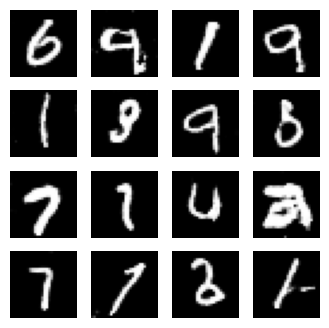

In [9]:
def generate_and_save_images(model, epoch, noise):
    model.eval()
    with torch.no_grad():
        fake_images = model(noise).cpu()
        fake_images = fake_images.view(fake_images.size(0), 28, 28)

        fig = plt.figure(figsize=(4, 4))
        for i in range(fake_images.size(0)):
            plt.subplot(4, 4, i + 1)
            plt.imshow(fake_images[i], cmap='gray')
            plt.axis('off')

        plt.savefig(f'image_at_epoch_{epoch+1:04d}.png')
        plt.show()


test_noise = torch.randn(16, NOISE_DIM, device=device)
generate_and_save_images(generator, NUM_EPOCHS, test_noise)